In [1]:
%matplotlib inline


# Bachelor Thesis - TDEM/FDEM 1D inversion


In [2]:
import numpy as np
from SimPEG.electromagnetics import time_domain
from SimPEG import (
    optimization,
    discretize,
    maps,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
import matplotlib.pyplot as plt

## Mesh and sigmas

### Mesh

We create the mesh grid

Text(0.5, 1.0, 'Tensor Mesh')

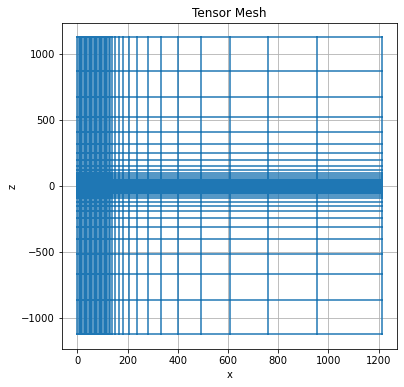

In [3]:
cs, ncx, ncz, npad = 5.0, 25, 15, 15
hx = [(cs, ncx), (cs, npad, 1.3)]
hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
mesh = discretize.CylMesh([hx, 1, hz], "00C")
# We can apply the plotGrid method and output to a specified axes object
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mesh.plotGrid(ax=ax)
ax.set_title("Tensor Mesh")

### Resistivity model

Very low conductivity, need high frquencies

In [4]:
layerz = np.r_[-700.0, -100.0]
layer = (mesh.vectorCCz >= layerz[0]) & (mesh.vectorCCz <= layerz[1])
active = mesh.vectorCCz < 0.0
actMap = maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap
sig_half = 1e-3
sig_air = 1e-8
sig_layer = 1e-4
sigma = np.ones(mesh.nCz) * sig_air
sigma[active] = sig_half
sigma[layer] = sig_layer
mtrue = np.log(sigma[active])

In [5]:
activeN = mesh.vectorNz <= 0.0 + cs / 2.0
z_true = np.repeat(mesh.vectorNz[activeN][1:-1], 2, axis=0)
z_true = np.r_[mesh.vectorNz[activeN][0], z_true, mesh.vectorNz[activeN][-1]]
sigma_true = np.repeat(sigma[active], 2, axis=0)

## TDEM

### Survey 

In [6]:
rxOffset = 1e-3
rx = time_domain.Rx.PointMagneticFluxTimeDerivative(
    np.array([[rxOffset, 0.0, 30]]), np.logspace(-5, -3, 31), "z"
)
src = time_domain.Src.MagDipole([rx], loc=np.array([0.0, 0.0, 80]))
survey = time_domain.Survey([src])
time_steps = [(1e-06, 20), (1e-05, 20), (0.0001, 20)]
simulation = time_domain.Simulation3DElectricField(
    mesh, sigmaMap=mapping, survey=survey, time_steps=time_steps
)

### Observed data 

Datas are created automatically

In [7]:
# create observed data
rel_err = 0.05
data = simulation.make_synthetic_data(mtrue, relative_error=rel_err)

dmisfit = data_misfit.L2DataMisfit(simulation=simulation, data=data)
regMesh = discretize.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = regularization.Tikhonov(regMesh, alpha_s=1e-2, alpha_x=1.0)
opt = optimization.InexactGaussNewton(maxIter=5, LSshorten=0.5)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

### Set up inversion 

In [8]:
# Create an inversion object
beta = directives.BetaSchedule(coolingFactor=4, coolingRate=2)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest])
m0 = np.log(np.ones(mtrue.size) * sig_half)
simulation.counter = opt.counter = utils.Counter()
opt.remember("xc")

### Inversion function and plot 

In [9]:
moptTD = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.68e+04  5.13e+04  0.00e+00  5.13e+04    5.14e+04      0              
   1  1.68e+04  1.18e+04  4.27e-01  1.89e+04    7.44e+03      0              
   2  4.19e+03  9.69e+03  4.94e-01  1.18e+04    9.22e+03      0              
   3  4.19e+03  4.56e+03  1.18e+00  9.51e+03    3.99e+03      0              
   4  1.05e+03  4.15e+03  1.12e+00  5.32e+03    4.77e+03      0              
   5  1.05e+03  3.16e+03  1.49e+00  4.72e+03    3.34e+03      1              
------------------------- STOP! -------------------------


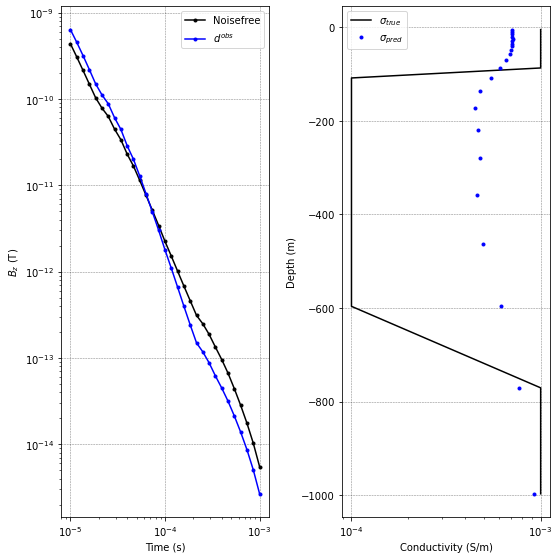

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].loglog(rx.times, -invProb.dpred, "k.-")
ax[0].loglog(rx.times, -data.dobs, "b.-")

ax[0].legend(("Noisefree", "$d^{obs}$"))
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("$B_z$ (T)")
ax[0].set_xlabel("Time (s)")
ax[0].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)

ax[1].semilogx(sigma[active], mesh.vectorCCz[active], 'k-')
ax[1].semilogx(np.exp(moptTD), mesh.vectorCCz[active], 'b.')
ax[1].set_xlabel("Conductivity (S/m)")
ax[1].set_ylabel("Depth (m)")
ax[1].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)
ax[1].legend(["$\sigma_{true}$", "$\sigma_{pred}$"])

plt.tight_layout(pad=1.5)

## FDEM 

### Survey 

In [11]:
from SimPEG.electromagnetics import frequency_domain as FDEM, time_domain as TDEM, mu_0
import matplotlib

In [12]:
rxlocs = utils.ndgrid([np.r_[50.0], np.r_[0], np.r_[0.0]])
bzr = FDEM.Rx.PointMagneticFluxDensitySecondary(rxlocs, "z", "real")
bzi = FDEM.Rx.PointMagneticFluxDensitySecondary(rxlocs, "z", "imag")
freqs = np.logspace(5, 6, 10) # choosing frequencies
srcLoc = np.array([0.0, 0.0, 0.0])

#### Frquency secondary field list

In [13]:
srcList = [FDEM.Src.MagDipole([bzr, bzi], freq, srcLoc, orientation="Z") for freq in freqs]

#### Activating survey and problem

In [14]:
surveyFD = FDEM.Survey(srcList)
prbFD = FDEM.Simulation3DMagneticFluxDensity(
    mesh, survey=surveyFD, sigmaMap=mapping)

### Setting up datas

In [15]:
rel_err = 0.03
dataFD = prbFD.make_synthetic_data(mtrue, relative_error=rel_err, add_noise=True)
dataFD.noise_floor = np.linalg.norm(dataFD.dclean) * 1e-5

### Setting up inversion

In [16]:
np.random.seed(1)
dmisfit = data_misfit.L2DataMisfit(simulation=prbFD, data=dataFD)
regMesh = discretize.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = regularization.Simple(regMesh)
opt = optimization.InexactGaussNewton(maxIterCG=10)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

### Inversion parameters

In [17]:
beta = directives.BetaSchedule(coolingFactor=4, coolingRate=3)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=2.0)
target = directives.TargetMisfit()
directiveList = [beta, betaest, target]

inv = inversion.BaseInversion(invProb, directiveList=directiveList)
m0 = np.log(np.ones(mtrue.size) * sig_layer)
reg.alpha_s = 5e-1
reg.alpha_x = 1e0
prbFD.counter = opt.counter = utils.Counter()
opt.remember("xc")

###  Inversion function and plot 

In [ ]:
moptFD = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.85e+02  2.11e+04  0.00e+00  2.11e+04    4.53e+03      0              
   1  4.85e+02  1.38e+04  2.44e+00  1.50e+04    5.05e+02      0              
   2  4.85e+02  1.32e+04  3.49e+00  1.48e+04    1.47e+02      0   Skip BFGS  
   3  1.21e+02  1.33e+04  3.20e+00  1.37e+04    7.12e+02      0              
   4  1.21e+02  1.18e+04  1.11e+01  1.31e+04    2.25e+02      0              
   5  1.21e+02  1.20e+04  8.15e+00  1.30e+04    6.68e+01      1              
   6  3.03e+01  1.19e+04  9.02e+00  1.22e+04    2.71e+02  

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

dpredFD = prbFD.dpred(moptTD)

ax[0].loglog( freqs, -dpredFD[::2], "b.", label="Pred (real)")
ax[0].loglog(freqs, -dpredFD[1::2], "bx", label="Pred (imag)")
ax[0].plot(freqs, -dataFD.dobs[::2], "k-", label="Obs (real)")
ax[0].plot(freqs, -dataFD.dobs[1::2], "k--", label="Obs (imag)")
#ax[0].set_xscale('symlog')
#ax[0].set_yscale('symlog')

ax[0].set_ylabel("$B_z$ [-T]")
ax[0].set_xlabel("Distance $[m]$")
ax[0].grid(which="both", alpha=0.5, linewidth=0.2)
ax[0].legend()


ax[1].semilogx(sigma_true, z_true, "k-", label="True")
ax[1].semilogx( np.exp(moptFD), mesh.vectorCCz[active], "b.", label="FDEM",)

ax[1].set_xlabel("Conductivity [S/m]")
ax[1].set_ylabel("Depth [m]")
ax[1].grid(which="both", alpha=0.5, linewidth=0.2)
ax[1].legend()

plt.tight_layout(pad=1.5)